In [31]:
import math
import sys
sys.path.append('../')
from fcts import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools,Draw
from rdkit.Chem.Draw import MolToImage
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'


In [2]:
# Load model
model = darkchem.utils.load_model('../../../DarKnight_File/Final Trained DarkChem Network Weights/N7b_[M+H]/') 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# load training set
x = np.load('../../../DarKnight_File/Training Data - Molecules/combined_[M+H]_smiles.npy')

In [11]:
# Define a fuction that can check the existance of our input molecules
def array_in_nd_array(test, array):
    """
    Checks whether or not a test 1D array is contained within a full N-D array.
    Returns True if the test array is equal to any of the dimensions of the N-D array.
    Returns False if the test array does not match any dimension of the N-D array.
    """
    return any(np.array_equal(x, test) for x in array)

In [12]:
# Define a fuction that transfer input molecules into vectors
def smi_vec_verify(dic):
    
    """Takes a dictionary with reactants and products.
    Creates vectorized representations and appends to dictionary
    as 'rvec' and 'pvec'.
    Checks that both vector types are contained within the loaded
    dataset x.
    
    """
    assert type(dic) == dict, 'Input must be a dictionary'
    assert len(dic) == 2, 'Input dictionary must contain 2 items (reactants, products)'
    
    dic['rvec'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in dic['reactants']]
    dic['pvec'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in dic['products']]
    
    is_in_testset = [[array_in_nd_array(item, x) for item in key] for key in dic.values()]
    
    print(f"Is each reactant contained in the DarkChem training set?: {is_in_testset[2]}")
    print(f"Is each product contained in the DarkChem training set?: {is_in_testset[3]}")
    
    return dic

In [13]:
# Define a function that generate the latent space and calulate the average reaction vector
def vec_latent_rxn_vector(dic):
    
    """Takes a dictionary with reaction vectors and product vectors.
    Converts vectorized representations to latent space vector
    representations and appends to dictionary as 'rlat' and 'plat'.
    
    Calculates reaction vector (subtraction of reactant latent space
    vector from product latent space vector.
    
    Displays Pearson correlation matrix for all reaction vectors.
    
    Averages all reaction vectors and returns dic, avgvec.
    
    """
    dic['rlat'] = model.encoder.predict(np.array(dic['rvec']))
    dic['plat'] = model.encoder.predict(np.array(dic['pvec']))
    
    dic['rxnvector'] = [dic['plat'][i] - dic['rlat'][i] for i in range(len(dic['plat']))]
    
    print(pd.DataFrame(np.corrcoef(dic['rxnvector']).view(type=np.matrix)))
    
    avgvec = np.array(dic['rxnvector']).sum(axis=0) / len(dic['rxnvector'])
    
    return dic, avgvec

In [14]:
# Define a function that apply the reaction vector to an input molecule
def apply_rxn_vector(smistr, rxnvec, nummols=10, savefilename=False):
    
    """Takes a SMILES string representation for a molecule.
    Adds input vector (e.g. avgvec output from vec_latent_rxn_vector)
    and shows chemical structures for the top 10 highest-probability
    product predictions (can be altered with nummols)
    
    """
    testvec = darkchem.utils.struct2vec(smistr).astype(np.int16)
    array_in_nd_array(testvec, x)
    
    testlat = model.encoder.predict(np.array(testvec.reshape(-1,100)))
    
    testprod = testlat + rxnvec
    testpvec = model.decoder.predict(testprod)
    testprods = darkchem.utils.beamsearch(testpvec, k=nummols)
    
    predictions = {}
    
    predictions['predprod'] = [darkchem.utils.vec2struct(i) for i in testprods[0]]
    predictions['predprodmol'] = [Chem.MolFromSmiles(predictions['predprod'][i])
                                  for i in range(len(predictions['predprod']))]
    
    if type(savefilename) == str:
        img = Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                        molsPerRow=5, subImgSize=(200, 200))
        img.save(f'./{savefilename}.png')
    
    return Chem.Draw.MolsToGridImage(predictions['predprodmol'],
                                     molsPerRow=5, subImgSize=(200, 200))

In [32]:
# load testing data
data = pd.read_excel('../../database/Alcohol_Dyhydration.xlsx')

#remove the redundant space in the smiles string
data = remove_space(data)

In [33]:
# Load several Alcohol Dehydration reactions
red = {'reactants': data['Reactants'],
       'products': data['Products']}

In [34]:
# Transfer the molecules above into vector and check the existance in the training set
red = smi_vec_verify(red)

Is each reactant contained in the DarkChem training set?: [False, False, False, True, True, True, True, True, True, True, True, True]
Is each product contained in the DarkChem training set?: [True, True, True, True, False, True, True, True, False, True, True, True]


In [35]:
# Generate the latent space
red, redvec = vec_latent_rxn_vector(red)

          0         1         2         3         4         5         6   \
0   1.000000  0.576913  0.502995  0.345671  0.330784  0.343978  0.276164   
1   0.576913  1.000000  0.916099  0.863099  0.778659  0.765092  0.534664   
2   0.502995  0.916099  1.000000  0.822517  0.933915  0.909939  0.801830   
3   0.345671  0.863099  0.822517  1.000000  0.856135  0.790154  0.494940   
4   0.330784  0.778659  0.933915  0.856135  1.000000  0.933646  0.848436   
5   0.343978  0.765092  0.909939  0.790154  0.933646  1.000000  0.813047   
6   0.276164  0.534664  0.801830  0.494940  0.848436  0.813047  1.000000   
7   0.313349  0.605863  0.789417  0.544088  0.779152  0.932597  0.822375   
8   0.276825  0.597956  0.796539  0.567848  0.804947  0.914291  0.821978   
9   0.358882  0.396801  0.327827  0.556524  0.382607  0.500829  0.126557   
10  0.269018  0.482008  0.680800  0.466856  0.695865  0.741895  0.667420   
11  0.478637  0.659520  0.681790  0.598615  0.627557  0.784550  0.515774   

          7

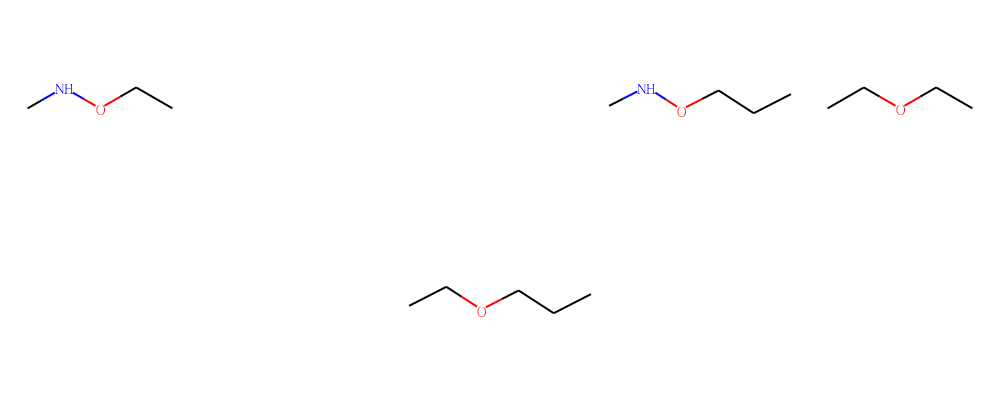

In [36]:
# Predict a certain molecule
ethanol = 'CCO'
ether = 'CCOCC'
apply_rxn_vector(ethanol, redvec, savefilename='Alcohol_Dehydration')